# DS6040, Fall '22

## Final Project

### Rory Black (qmn9tb), Gargee Jagtap (wra2jv), Ali Roth (wat6sv)

Buying wine can be a challenging and expensive process to be able to determine a “good” wine from a “bad” one. We propose using “A Study of Wine Quality of red & white vinho verde wine samples from the Northern region of Portugal” to develop a Bayesian Model to determine if a wine is “good” or “bad” based on the physicochemical properties that could be used by consumers to determine what wines they should buy, or by distributors to determine price. Our goals for this project are to 1) Classify the wine quality as “good” (7-10), or “bad” (1-6) given attributes based on physicochemical tests and 2) Evaluate the posterior probability distributions of the regression parameters for the predictor variables. The data are from Kaggle, originally from the UCI machine learning repository, and consist of 11 predictor variables and 1 sensory response variable. We propose to use logistic regression with Hamiltonian Monte Carlo Sampling technique and will investigate 1) a main effects model; 2) a simpler model; 3) a variational inference estimate using ADVI optimization; and 4) a Bayesian model averaging model.

# Data Cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
import pymc as pm
import arviz as az
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns

/home/wat6sv/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
red = pd.read_csv('WineQuality-RedWine.csv')
white = pd.read_csv('WineQuality-WhiteWine.csv')

In [3]:
# add column 'type' representing wine color
red['type']="red"
white['type']="white"

# concatenate both dataframes
wines = pd.concat([red,white])

# recode wine quality
wines['quality'] = np.where(wines['quality'] < 7, 0, 1)

In [4]:
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,red


<AxesSubplot:>

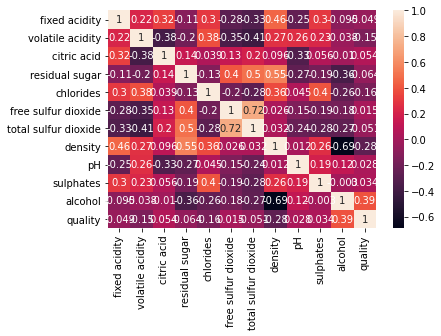

In [5]:
sns.heatmap(wines.corr(), annot = True)

We see that `free sulfur dioxide` and `total sulfur dioxide` have a relatively high correlation. This makes sense since these are different measures of the same quantity. We also see that `alcohol` and `density` have a high correlation. This also makes sense alcohol content will impact the overall density of the liquid.

In [6]:
wines.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'type'],
      dtype='object')

In [7]:
# standardize numeric variables

# Numeric predictors

numeric_predictors = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 
                'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
                'pH', 'sulphates', 'alcohol']
n = wines.shape[0]

# Numeric, categorical predictors and response, y`

x_num = wines[numeric_predictors]
x_cat = wines['type']
y = wines['quality']

all_predictors = numeric_predictors
all_predictors.append('type')

# No. of predictors
k = len(all_predictors)

In [8]:
def clean(wines):
    numeric_predictors = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 
                'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
                'pH', 'sulphates', 'alcohol']
    n = wines.shape[0]

    # Numeric, categorical predictors and response, y`

    x_num = wines[numeric_predictors]
    x_cat = wines['type']
    y = wines['quality']

    all_predictors = numeric_predictors
    all_predictors.append('type')

    # No. of predictors
    k = len(all_predictors)
    
    # Standardize numeric columns, to mean 0 variance 1
    mean = x_num.mean()
    std = x_num.std()
    x_num = np.array((x_num - mean) / std)

    # Convert categorical predictor column to a dummy variable
    # + 0 forces numeric type
    x_cat = np.array(wines['type'] == 'red').reshape((n,1))

    # Put them into one data matrix

    X = np.concatenate((x_num, x_cat), axis = 1)
    
    return X, y

In [9]:
train, test = train_test_split(wines, train_size = 0.7, test_size=0.3, random_state = 895)
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
3127,7.6,0.300,0.38,2.1,0.043,10.0,98.0,0.99296,3.17,0.65,11.0,0,white
1235,6.0,0.330,0.32,12.9,0.054,6.0,113.0,0.99572,3.30,0.56,11.5,0,red
3770,7.4,0.270,0.31,2.4,0.014,15.0,143.0,0.99094,3.03,0.65,12.0,0,white
147,6.4,0.595,0.14,5.2,0.058,15.0,97.0,0.99510,3.38,0.36,9.0,0,white
1100,8.4,0.340,0.42,2.1,0.072,23.0,36.0,0.99392,3.11,0.78,12.4,0,red


In [10]:
X, y = clean(train)

# Main Effects Model

In [11]:
# Build the model with priors and run the sampling
with pm.Model() as full_model:
    
    # Intercept term & prior
    B0 = pm.Normal('B0', mu=0, sigma=10)
    # Beta coefficients for predictor variables & priors
    B = pm.MvNormal('B', mu=np.zeros(k), cov=10*np.eye(k), shape=k)
    
    # Calculate the logit 
    u = B0 + pm.math.dot(X, B)
    p = pm.Deterministic('p', pm.invlogit(u))
    
    # Pass the logits to a Bernoulli outcome, with the observed data
    y_hat = pm.Bernoulli('y_hat', p=p, observed=y)

    trace_main = pm.sample(1000, cores = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [B0, B]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 111 seconds.


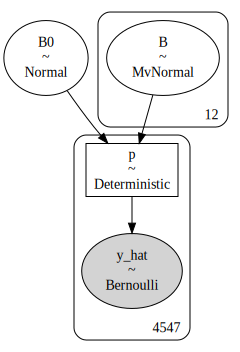

In [12]:
# The graphical model
pm.model_to_graphviz(full_model)

In [13]:
az.summary(trace_main, var_names=['B','B'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
B[0],0.72,0.11,0.53,0.91,0.00,0.00,885.39,1387.28,1.0
B[1],-0.56,0.08,-0.70,-0.41,0.00,0.00,1668.71,1427.68,1.0
B[2],0.00,0.06,-0.10,0.13,0.00,0.00,1598.47,1384.29,1.0
B[3],1.14,0.16,0.84,1.40,0.01,0.00,756.69,970.41,1.0
B[4],-0.31,0.11,-0.49,-0.10,0.00,0.00,1603.86,1346.76,1.0
B[5],0.15,0.06,0.04,0.27,0.00,0.00,1692.89,1415.18,1.0
B[6],-0.17,0.09,-0.34,-0.01,0.00,0.00,1275.70,1256.66,1.0
B[7],-1.42,0.25,-1.86,-0.95,0.01,0.01,698.95,995.63,1.0
B[8],0.48,0.07,0.35,0.62,0.00,0.00,1052.11,1388.03,1.0
B[9],0.39,0.05,0.29,0.48,0.00,0.00,2098.90,1477.31,1.0


We can see that credible interval for B[2] (`citric acid`) includes 0, so we will consider that predictor to be insignificant.
We also see $\hat{R} = 1$, indicating that the sample distributions are converging to our desired distribution. We will also view the traceplots to visualize this.

array([[<AxesSubplot:title={'center':'B0'}>,
        <AxesSubplot:title={'center':'B0'}>],
       [<AxesSubplot:title={'center':'B\n0'}>,
        <AxesSubplot:title={'center':'B\n0'}>],
       [<AxesSubplot:title={'center':'B\n1'}>,
        <AxesSubplot:title={'center':'B\n1'}>],
       [<AxesSubplot:title={'center':'B\n2'}>,
        <AxesSubplot:title={'center':'B\n2'}>],
       [<AxesSubplot:title={'center':'B\n3'}>,
        <AxesSubplot:title={'center':'B\n3'}>],
       [<AxesSubplot:title={'center':'B\n4'}>,
        <AxesSubplot:title={'center':'B\n4'}>],
       [<AxesSubplot:title={'center':'B\n5'}>,
        <AxesSubplot:title={'center':'B\n5'}>],
       [<AxesSubplot:title={'center':'B\n6'}>,
        <AxesSubplot:title={'center':'B\n6'}>],
       [<AxesSubplot:title={'center':'B\n7'}>,
        <AxesSubplot:title={'center':'B\n7'}>],
       [<AxesSubplot:title={'center':'B\n8'}>,
        <AxesSubplot:title={'center':'B\n8'}>],
       [<AxesSubplot:title={'center':'B\n9'}>,
       

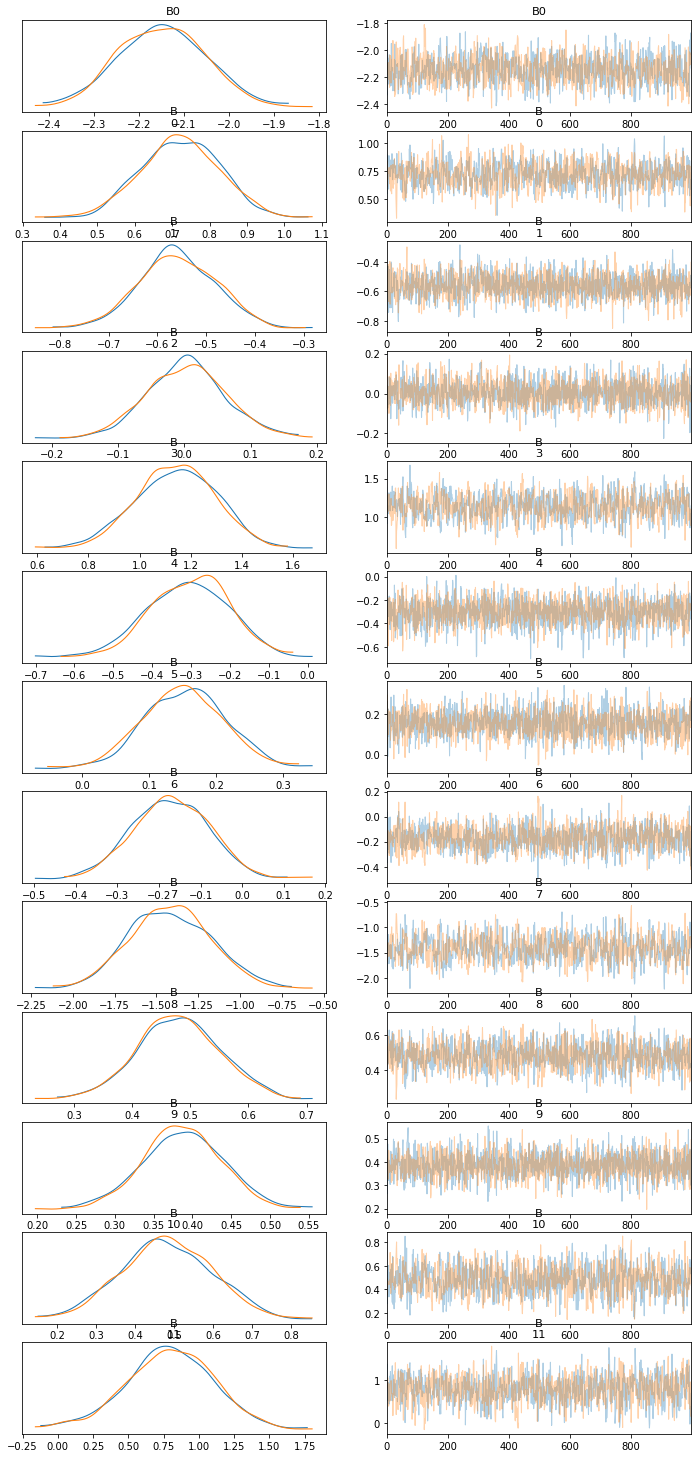

In [14]:
az.plot_trace(trace_main, var_names=['B0','B'],compact =False)

The traceplots also show good convergence. 

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

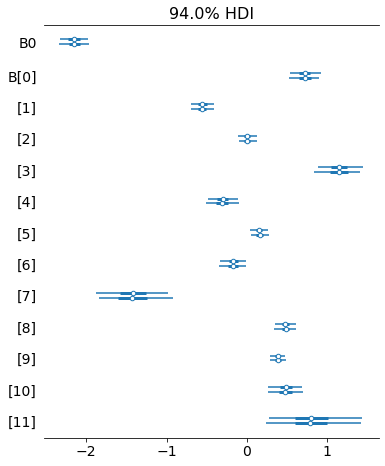

In [15]:
az.plot_forest(trace_main, var_names=['B0','B'])

We can also see that credible interevals for predictors B[11] (wine type, red & white) and B[7] (density) are wider than the others. This demonstrate that there is more uncertainty in these predictors than the others.

# Reduced Model 1: Bottle info

In the reduced model, we are going to use physiochemical properties that are usually listed on wine bottles. These are `alcohol`, `type`, and `sulfates`. This is documented on https://www.bluelabelpackaging.com/blog/anatomy-wine-label/.

In [16]:
# Model 2 

X_bottle = X[...,[9,10,11]]
k_bottle = X_bottle.shape[1]

with pm.Model() as bottle_model:
    
    x = pm.MutableData("x", X_bottle)
    Y = pm.MutableData("Y", y)
    
    # Intercept term & prior
    B0 = pm.Normal('B0', mu=0, sigma=10)
    # Beta coefficients for predictor variables & priors
    B = pm.MvNormal('B', mu=np.zeros(k_bottle), cov=10*np.eye(k_bottle), shape=k_bottle)
    
    # Calculate the logit 
    u = B0 + pm.math.dot(x, B)
    p = pm.Deterministic('p', pm.invlogit(u))
    
    # Pass the logits to a Bernoulli outcome, with the observed data
    y_hat = pm.Bernoulli('y_hat', p=p, observed=Y)

    trace_bottle = pm.sample(1000, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [B0, B]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


In [17]:
az.summary(trace_bottle, var_names=['B0','B'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
B0,-1.53,0.05,-1.62,-1.42,0.0,0.0,2829.13,2868.49,1.0
B[0],0.30,0.04,0.21,0.38,0.0,0.0,2830.50,3270.79,1.0
B[1],1.00,0.04,0.93,1.09,0.0,0.0,3050.63,3075.99,1.0
B[2],-0.91,0.12,-1.14,-0.68,0.0,0.0,2850.09,2909.27,1.0


array([[<AxesSubplot:title={'center':'B0'}>,
        <AxesSubplot:title={'center':'B0'}>],
       [<AxesSubplot:title={'center':'B\n0'}>,
        <AxesSubplot:title={'center':'B\n0'}>],
       [<AxesSubplot:title={'center':'B\n1'}>,
        <AxesSubplot:title={'center':'B\n1'}>],
       [<AxesSubplot:title={'center':'B\n2'}>,
        <AxesSubplot:title={'center':'B\n2'}>]], dtype=object)

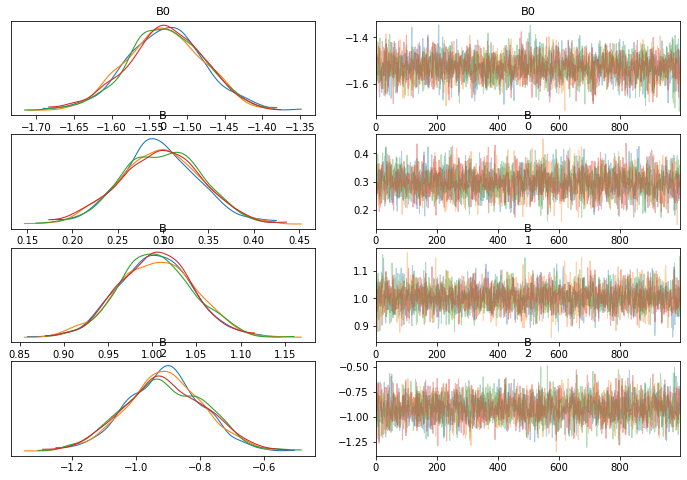

In [18]:
az.plot_trace(trace_bottle, var_names=['B0','B'],compact =False)

# Reduced Model 2: low uncertainty

In this reduced model, we are going to use the predictors with the smallest credible intervals indicating reduced uncertainty. These are `volatile acidity`, `free sulfur dioxide`, and `pH`, and `sulphates`. All predictors have credible intervals with sd $\leq$ 0.08

In [19]:
# Model 3

X_sd = X[...,[1, 5, 8, 9]]
k_sd = X_sd.shape[1]

with pm.Model() as sd_model:
    
    x = pm.MutableData("x", X_sd)
    Y = pm.MutableData("Y", y)
    
    # Intercept term & prior
    B0 = pm.Normal('B0', mu=0, sigma=1)
    # Beta coefficients for predictor variables & priors
    B = pm.MvNormal('B', mu=np.zeros(k_sd), cov=np.eye(k_sd), shape=k_sd)
    
    
    # Calculate the logit 
    u = B0 + pm.math.dot(x,B)
    p = pm.Deterministic('p',  pm.invlogit(u))
    # Pass the logits to a Bernoulli outcome, with the observed data
    y_hat = pm.Bernoulli('y_hat', p=p, observed=Y) 
    
    # Sample
    trace_sd = pm.sample(1000, cores = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [B0, B]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.


In [20]:
az.summary(trace_sd, var_names=['B0','B'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
B0,-1.52,0.04,-1.59,-1.44,0.0,0.0,1767.48,1486.45,1.0
B[0],-0.60,0.05,-0.70,-0.51,0.0,0.0,1460.12,1529.64,1.0
B[1],-0.09,0.04,-0.17,-0.01,0.0,0.0,2133.03,1466.70,1.0
B[2],0.15,0.04,0.08,0.22,0.0,0.0,3003.05,1653.06,1.0
B[3],0.17,0.04,0.09,0.24,0.0,0.0,2411.26,1506.06,1.0


array([[<AxesSubplot:title={'center':'B0'}>,
        <AxesSubplot:title={'center':'B0'}>],
       [<AxesSubplot:title={'center':'B\n0'}>,
        <AxesSubplot:title={'center':'B\n0'}>],
       [<AxesSubplot:title={'center':'B\n1'}>,
        <AxesSubplot:title={'center':'B\n1'}>],
       [<AxesSubplot:title={'center':'B\n2'}>,
        <AxesSubplot:title={'center':'B\n2'}>],
       [<AxesSubplot:title={'center':'B\n3'}>,
        <AxesSubplot:title={'center':'B\n3'}>]], dtype=object)

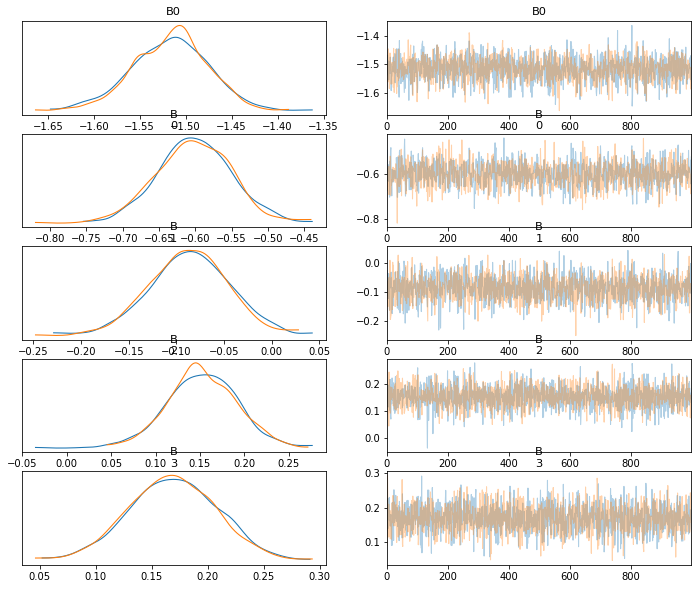

In [21]:
az.plot_trace(trace_sd, var_names=['B0','B'],compact =False)

In [22]:
# WAIC
cmp_waic = az.compare({'full_model':trace_main,'bottle_model':trace_bottle, 'sd_model':trace_sd}, 
                     ic = 'WAIC',  scale='deviance')
cmp_waic

/home/wat6sv/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1644: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
full_model,0,3547.084046,13.142474,0.000000,9.596371e-01,76.506848,0.000000,True,deviance
bottle_model,1,3737.021824,4.099897,189.937777,8.243522e-12,78.562126,26.710125,False,deviance
sd_model,2,4306.263639,4.682492,759.179593,4.036290e-02,75.887896,56.204661,False,deviance


WAIC shows that the main effect model is preferred over the simpler model

In [23]:
# LOO
cmp_loo = az.compare({'full_model':trace_main,'bottle_model':trace_bottle, 'sd_model':trace_sd}, 
                     ic = 'LOO',  scale='deviance')
cmp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
full_model,0,3547.169189,13.185046,0.000000,9.595747e-01,76.509947,0.000000,False,deviance
bottle_model,1,3737.034063,4.106017,189.864874,4.124743e-12,78.562442,26.712871,False,deviance
sd_model,2,4306.288580,4.694962,759.119391,4.042534e-02,75.888435,56.207255,False,deviance


# Reduced Model 3: remove citric acid

In this reduced model, we are going to remove the predictors that were deemed insignifciant (B[2], `citric acid`) and keep all other predictors.

In [24]:
# Model 4

X_reduced = X[...,[0,1,3,4,5,6,7,8,9,10,11]]
k_reduced = X_reduced.shape[1]

with pm.Model() as reduced_model:
    
    x = pm.MutableData("x", X_reduced)
    Y = pm.MutableData("Y", y)
     
    # Intercept term & prior
    B0 = pm.Normal('B0', mu=0, sigma=1)
    # Beta coefficients for predictor variables & priors
    B = pm.MvNormal('B', mu=np.zeros(k_reduced), cov=np.eye(k_reduced), shape=k_reduced)
    
    
    
    # Calculate the logit 
    u = B0 + pm.math.dot(x,B)
    p = pm.Deterministic('p',  pm.invlogit(u))
    # Pass the logits to a Bernoulli outcome, with the observed data
    y_hat = pm.Bernoulli('y_hat', p=p, observed=Y, shape=x.shape[0]) 
    
    # Sample
    trace_reduced = pm.sample(1000, cores = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [B0, B]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 102 seconds.


In [25]:
az.summary(trace_reduced, var_names=['B0','B'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
B0,-2.09,0.09,-2.26,-1.93,0.00,0.00,998.81,1232.14,1.0
B[0],0.67,0.10,0.49,0.86,0.00,0.00,839.52,1387.47,1.0
B[1],-0.55,0.07,-0.69,-0.42,0.00,0.00,1631.88,1402.49,1.0
B[2],1.04,0.14,0.77,1.31,0.01,0.00,730.68,1096.65,1.0
B[3],-0.30,0.11,-0.50,-0.10,0.00,0.00,1747.14,1429.75,1.0
B[4],0.16,0.06,0.04,0.28,0.00,0.00,1896.10,1606.51,1.0
B[5],-0.19,0.09,-0.36,-0.02,0.00,0.00,1733.47,1650.37,1.0
B[6],-1.25,0.23,-1.65,-0.82,0.01,0.01,676.86,759.45,1.0
B[7],0.45,0.07,0.32,0.57,0.00,0.00,1050.75,1637.94,1.0
B[8],0.38,0.05,0.28,0.47,0.00,0.00,1903.84,1438.83,1.0


array([[<AxesSubplot:title={'center':'B0'}>,
        <AxesSubplot:title={'center':'B0'}>],
       [<AxesSubplot:title={'center':'B\n0'}>,
        <AxesSubplot:title={'center':'B\n0'}>],
       [<AxesSubplot:title={'center':'B\n1'}>,
        <AxesSubplot:title={'center':'B\n1'}>],
       [<AxesSubplot:title={'center':'B\n2'}>,
        <AxesSubplot:title={'center':'B\n2'}>],
       [<AxesSubplot:title={'center':'B\n3'}>,
        <AxesSubplot:title={'center':'B\n3'}>],
       [<AxesSubplot:title={'center':'B\n4'}>,
        <AxesSubplot:title={'center':'B\n4'}>],
       [<AxesSubplot:title={'center':'B\n5'}>,
        <AxesSubplot:title={'center':'B\n5'}>],
       [<AxesSubplot:title={'center':'B\n6'}>,
        <AxesSubplot:title={'center':'B\n6'}>],
       [<AxesSubplot:title={'center':'B\n7'}>,
        <AxesSubplot:title={'center':'B\n7'}>],
       [<AxesSubplot:title={'center':'B\n8'}>,
        <AxesSubplot:title={'center':'B\n8'}>],
       [<AxesSubplot:title={'center':'B\n9'}>,
       

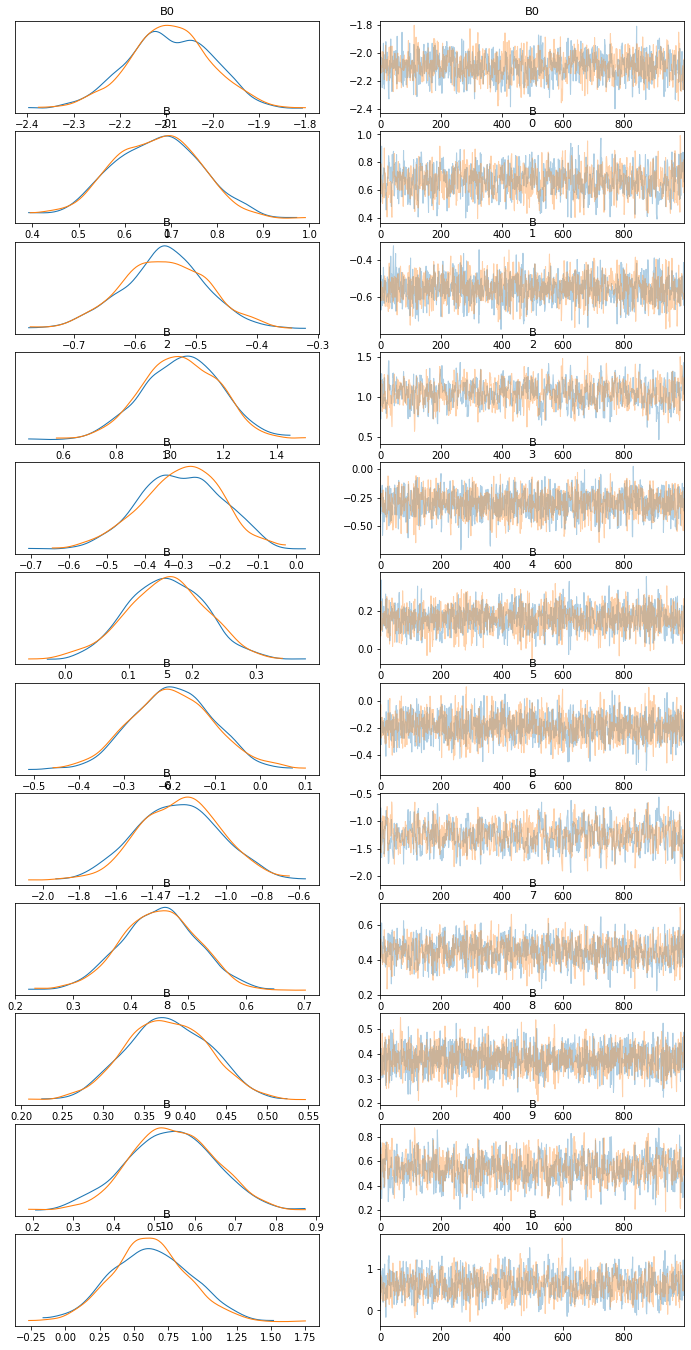

In [26]:
az.plot_trace(trace_reduced, var_names=['B0','B'],compact =False)

In [27]:
# WAIC
cmp_waic = az.compare({'full_model':trace_main,'bottle_model':trace_bottle, 'sd_model':trace_sd,'reduced_model':trace_reduced}, 
                     ic = 'WAIC',  scale='deviance')
cmp_waic

/home/wat6sv/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1644: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/wat6sv/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1644: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
reduced_model,0,3544.874904,11.770428,0.000000,9.649327e-01,76.004580,0.000000,True,deviance
full_model,1,3547.084046,13.142474,2.209142,2.808866e-11,76.506848,1.459146,True,deviance
bottle_model,2,3737.021824,4.099897,192.146920,0.000000e+00,78.562126,25.944153,False,deviance
sd_model,3,4306.263639,4.682492,761.388735,3.506731e-02,75.887896,55.868906,False,deviance


WAIC shows that the main effect model is preferred over the simpler model

In [28]:
# LOO
cmp_loo = az.compare({'full_model':trace_main,'bottle_model':trace_bottle, 'sd_model':trace_sd,'reduced_model':trace_reduced}, 
                     ic = 'LOO',  scale='deviance')
cmp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
reduced_model,0,3544.940139,11.803046,0.000000,9.649006e-01,76.006326,0.000000,False,deviance
full_model,1,3547.169189,13.185046,2.229050,0.000000e+00,76.509947,1.459775,False,deviance
bottle_model,2,3737.034063,4.106017,192.093924,2.808240e-11,78.562442,25.944952,False,deviance
sd_model,3,4306.288580,4.694962,761.348441,3.509937e-02,75.888435,55.870052,False,deviance


LOO results are consistent with the WAIC.

In [29]:
# BMA weights

w = cmp_waic.loc[:,'weight']

b_main = trace_main.posterior['B']
b_reduced = trace_reduced.posterior['B']
b_bottle = trace_bottle.posterior['B']
b_sd = trace_sd.posterior['B']

b_bma = w[0]*b_reduced + w[1]*b_main + w[2]*b_bottle + w[3]*b_sd

Now we want to look at how the models compare on the pH predictor, since that is the most normally distributed.

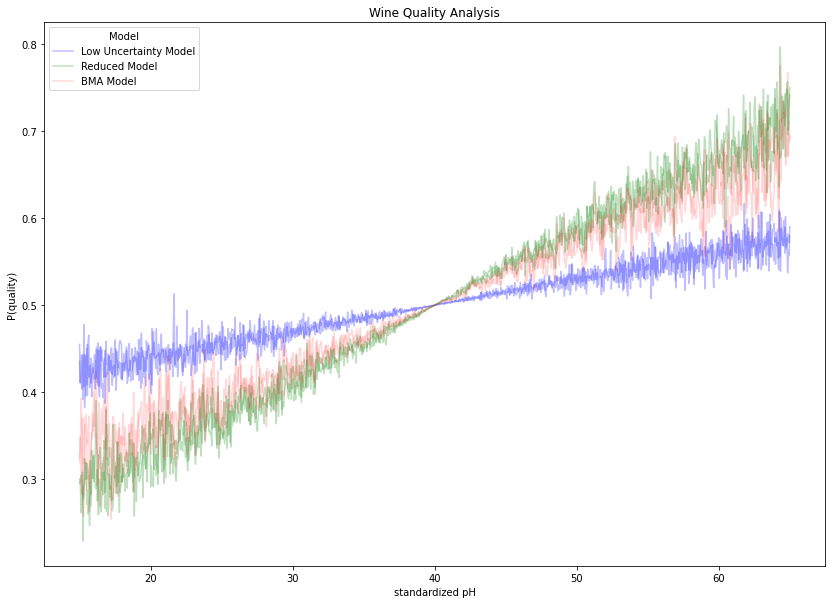

In [30]:
# Plot of the models
# models = ['main','simple']
colors = ['blue', 'green']
shape = trace_main.posterior['B0'].shape
x = np.linspace(-2, 2, shape[1])
x = np.array(x)
z = np.broadcast_to(x, shape)
pH = np.linspace(15,65, shape[1])

plt.figure(figsize = (14,10))

sd_post = 1/(1 + np.exp(-trace_sd.posterior['B'][:,:,2]*z))
out =[]
for i in range(2):
    out.append(sd_post[i,:])
    if i == 0:
        plt.plot(pH,out[i], color = 'blue', label = 'Low Uncertainty Model', alpha = .25)
    else:
        plt.plot(pH,out[i], color = 'blue',alpha = .25)
        
simple_post = 1/(1 + np.exp(-trace_reduced.posterior['B'][:,:,7]*z))
out =[]
for i in range(2):
    out.append(simple_post[i,:])
    if i == 0:
        plt.plot(pH,out[i], color = 'green', label = 'Reduced Model',alpha = .25)
    else:
        plt.plot(pH,out[i], color = 'green',alpha = .25)
        

bma_post = 1/(1 + np.exp(-b_bma.mean(axis=2)*z))
out =[]
for i in range(2):
    out.append(bma_post[i,:])
    if i == 0:
        plt.plot(pH,out[i], color = 'red', label = 'BMA Model',alpha = .15)
    else:
        plt.plot(pH,out[i], color = 'red',alpha = .15)
        

plt.title("Wine Quality Analysis")
plt.xlabel("standardized pH") 
plt.ylabel("P(quality)")#, title="Binomial regression")
plt.legend(title ="Model")

The BMA is closer to the main effects since it weights that model more.

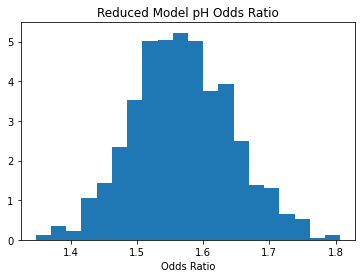

In [31]:
# Reduced Model pH Odds Ratio

b = trace_reduced.posterior['B'][:,:,7]
OR = np.mean(b, axis =0)
plt.hist(np.exp(OR), bins=20, density=True)
plt.xlabel("Odds Ratio")
plt.title("Reduced Model pH Odds Ratio")
plt.show()

In [32]:
# 95% CI for pH Odds Ratio

lb, ub = np.percentile(OR, 2.5), np.percentile(OR, 97.5)

print("P({:.3f} < O.R. < {:.3f}) = 0.95".format(np.exp(lb), np.exp(ub)))

P(1.427 < O.R. < 1.724) = 0.95


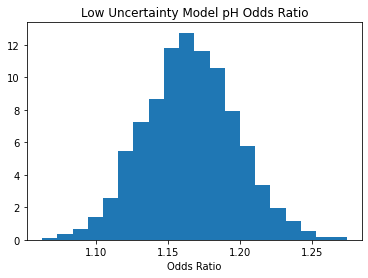

In [33]:
# Reduced Model pH Odds Ratio

b = trace_sd.posterior['B'][:,:,2]
OR = np.mean(b, axis =0)
plt.hist(np.exp(OR), bins=20, density=True)
plt.xlabel("Odds Ratio")
plt.title("Low Uncertainty Model pH Odds Ratio")
plt.show()

In [34]:
# 95% CI for pH Odds Ratio

lb, ub = np.percentile(OR, 2.5), np.percentile(OR, 97.5)

print("P({:.3f} < O.R. < {:.3f}) = 0.95".format(np.exp(lb), np.exp(ub)))

P(1.103 < O.R. < 1.230) = 0.95


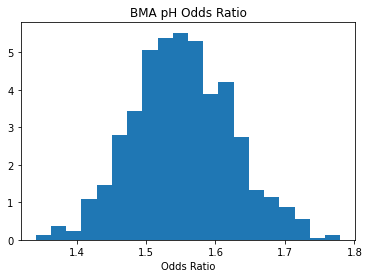

In [35]:
# BMA Odds Ratio


w = cmp_waic.loc[:,'weight']

b_reduced = trace_reduced.posterior['B'][:,:,7]
b_sd = trace_sd.posterior['B'][:,:,2]
b = w[0]*b_reduced + w[3]*b_sd
OR = np.mean(b, axis =0)
plt.hist(np.exp(OR), bins=20, density=True)
plt.xlabel("Odds Ratio")
plt.title("BMA pH Odds Ratio")
plt.show()

In [36]:
# 95% CI for Age Odds Ratio

lb, ub = np.percentile(OR, 2.5), np.percentile(OR, 97.5)

print("P({:.3f} < O.R. < {:.3f}) = 0.95".format(np.exp(lb), np.exp(ub)))

P(1.418 < O.R. < 1.701) = 0.95


The odds ratios show that the reduced model with more variables than the low uncertainty model pushes the odds ratio higher. The BMA model odds ratio is closer to the reduced model since that is weighted higher.

## Predict with Reduced Model

In [37]:
test_x, test_y = clean(test)

Predict with the test data in the reduced model:

In [38]:
testX_reduced = test_x[...,[0,1,3,4,5,6,7,8,9,10,11]]

with reduced_model:
    pm.set_data({"x": testX_reduced})
    pm.set_data({"Y": test_y})
   
    y_test = pm.sample_posterior_predictive(trace_reduced)

preds = y_test.posterior_predictive['y_hat'].mean(('chain', 'draw'))


Sampling: [y_hat]


In [39]:
preds_list = list(preds.values)

Now we look at the histogram of the predicted probabilities, which we see is skewed right. This makes sense as our dataset has far more "bad" wines than "good".

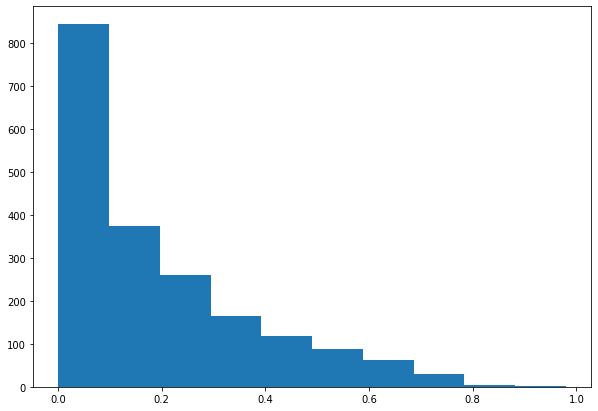

In [40]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(preds_list)
 
# Show plot
plt.show()

In [41]:
test["preds"] = preds_list
test.head()

<ipython-input-41-67518c835f74>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["preds"] = preds_list


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type,preds
3592,5.6,0.28,0.27,3.9,0.043,52.0,158.0,0.99202,3.35,0.44,10.7,1,white,0.1700
899,8.3,1.02,0.02,3.4,0.084,6.0,11.0,0.99892,3.48,0.49,11.0,0,red,0.0095
864,7.2,0.62,0.06,2.7,0.077,15.0,85.0,0.99746,3.51,0.54,9.5,0,red,0.0175
1550,7.9,0.18,0.49,5.2,0.051,36.0,157.0,0.99530,3.18,0.48,10.6,0,white,0.1395
2415,8.2,0.24,0.30,2.3,0.050,23.0,106.0,0.99397,2.98,0.50,10.0,0,white,0.0670


In [42]:
# cost of fp = 1.1, cost of fn= 1

threshold = 1.1/2.1 

# classify each prediction using threshold
test['pred_class'] = np.where(test['preds'] < threshold, 0, 1)
test.head()

<ipython-input-42-0ff258ee6631>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_class'] = np.where(test['preds'] < threshold, 0, 1)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type,preds,pred_class
3592,5.6,0.28,0.27,3.9,0.043,52.0,158.0,0.99202,3.35,0.44,10.7,1,white,0.1700,0
899,8.3,1.02,0.02,3.4,0.084,6.0,11.0,0.99892,3.48,0.49,11.0,0,red,0.0095,0
864,7.2,0.62,0.06,2.7,0.077,15.0,85.0,0.99746,3.51,0.54,9.5,0,red,0.0175,0
1550,7.9,0.18,0.49,5.2,0.051,36.0,157.0,0.99530,3.18,0.48,10.6,0,white,0.1395,0
2415,8.2,0.24,0.30,2.3,0.050,23.0,106.0,0.99397,2.98,0.50,10.0,0,white,0.0670,0


In [43]:
TP = len(test[(test["quality"]==1) & (test["pred_class"]==1)])
TN = len(test[(test["quality"]==0) & (test["pred_class"]==0)])
FP = len(test[(test["quality"]==0) & (test["pred_class"]==1)])
FN = len(test[(test["quality"]==1) & (test["pred_class"]==0)])

row1 = (FP + TN)
row2 = (TP + FN)
TP_prop = round(TP / row2, 2)
FN_prop = round(FN / row2, 2)
TN_prop = round(TN / row1, 2)
FP_prop = round(FP / row1, 2)
print("True Positive: ", TP_prop)
print("True Negative: ", TN_prop)
print("False Positive: ", FP_prop)
print("False Negative: ", FN_prop)

True Positive:  0.25
True Negative:  0.96
False Positive:  0.04
False Negative:  0.75


Now we generate the confusion matrix to see our TP, TN, FP, FN proportions in our predictions.

### Confusion Matrix

|            |   | Pred Value |      |
|------------|---|------------|------|
|            |   | 0          | 1    |
| True Value | 0 | 0.97       | 0.03 |
|            | 1 | 0.82         | 0.18 |

### Accuracy

In [44]:
print("Accuracy: ", str(round((TP+TN)/(TP+TN+FP+FN),4)*100), "%")

Accuracy:  81.89999999999999 %


### Precision

In [45]:
print("Precision: ", str(round((TP)/(TP+FP),4)*100), "%")

Precision:  64.52 %


# ADVI

We want to run the same reduced model using ADVI instead of sampling to see how the variational inference approach compares to the sampling to gain insight on how this could be scaled up in the futrue with more data that would make sampling inefficient. 

Finished [100%]: Average Loss = 811.25


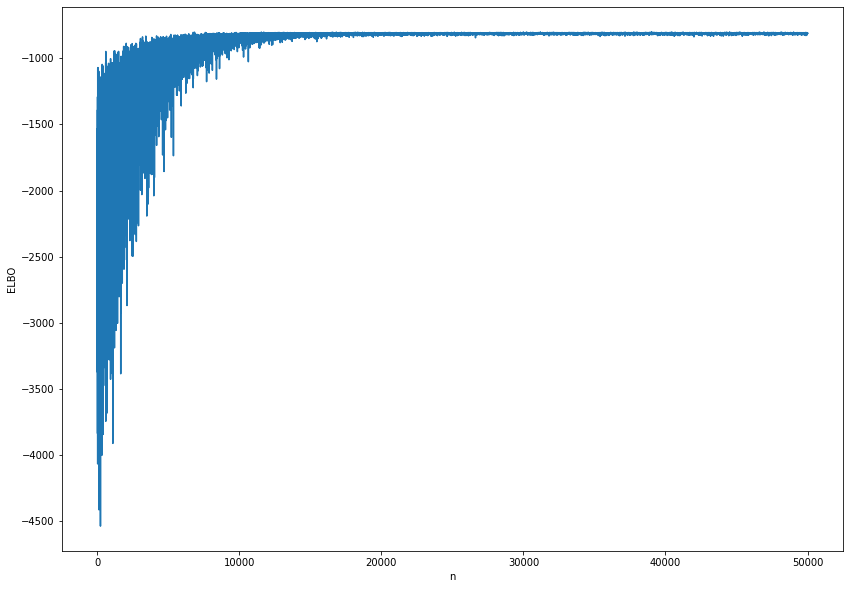

In [46]:
# Variational Inference with ADVI optimization
advi_fit = pm.fit(50000, method = 'advi', model = reduced_model)

# plot the elbo vs fitting time or iterations
advi_elbo = pd.DataFrame(
    {'ELBO': -advi_fit.hist,
     'n': np.arange(advi_fit.hist.shape[0])})


plt.figure(figsize=(14,10))
ax = sns.lineplot(y='ELBO',x='n', data = advi_elbo)

We see good convergence of the ELBO plot when n>15000 at ELBO ~= -900.

In [47]:
# sample from the variational posterior distribution
advi_trace = advi_fit.sample(5000)

Text(0.5, 1.0, 'Sampling 94% HDI')

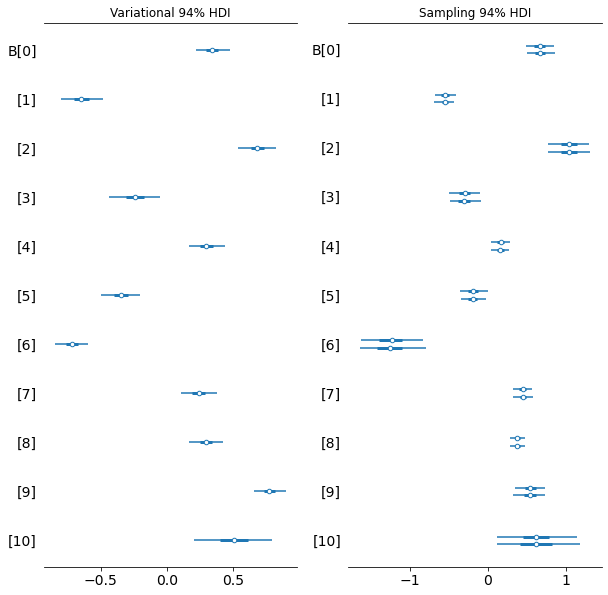

In [48]:
# Comparison of Variational and Sampling methods 
# Parameter posteriors in a forest plot

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(10,10))


pm.plot_forest(advi_trace, var_names=['B'], ax = ax1, figsize = (30,15))
pm.plot_forest(trace_reduced, var_names=['B'], ax = ax2, figsize = (30,15))
ax1.set_title('Variational 94% HDI')
ax2.set_title('Sampling 94% HDI')



We see that the variational and sampling forest plots are very similar, indicating that variational inference performs well and would be a good approach to use if the data was to scale up and sampling because inefficient. The credible intervals on the variational inference plot seem to have a more uniform spread, while the sampling credible intervals range with some being very narrow and some very wide. The variational inference plot shows good middle ground that does not seem to fit the data too cloasely, again supporting ADVI as an approach that could be used in scaling up the model.

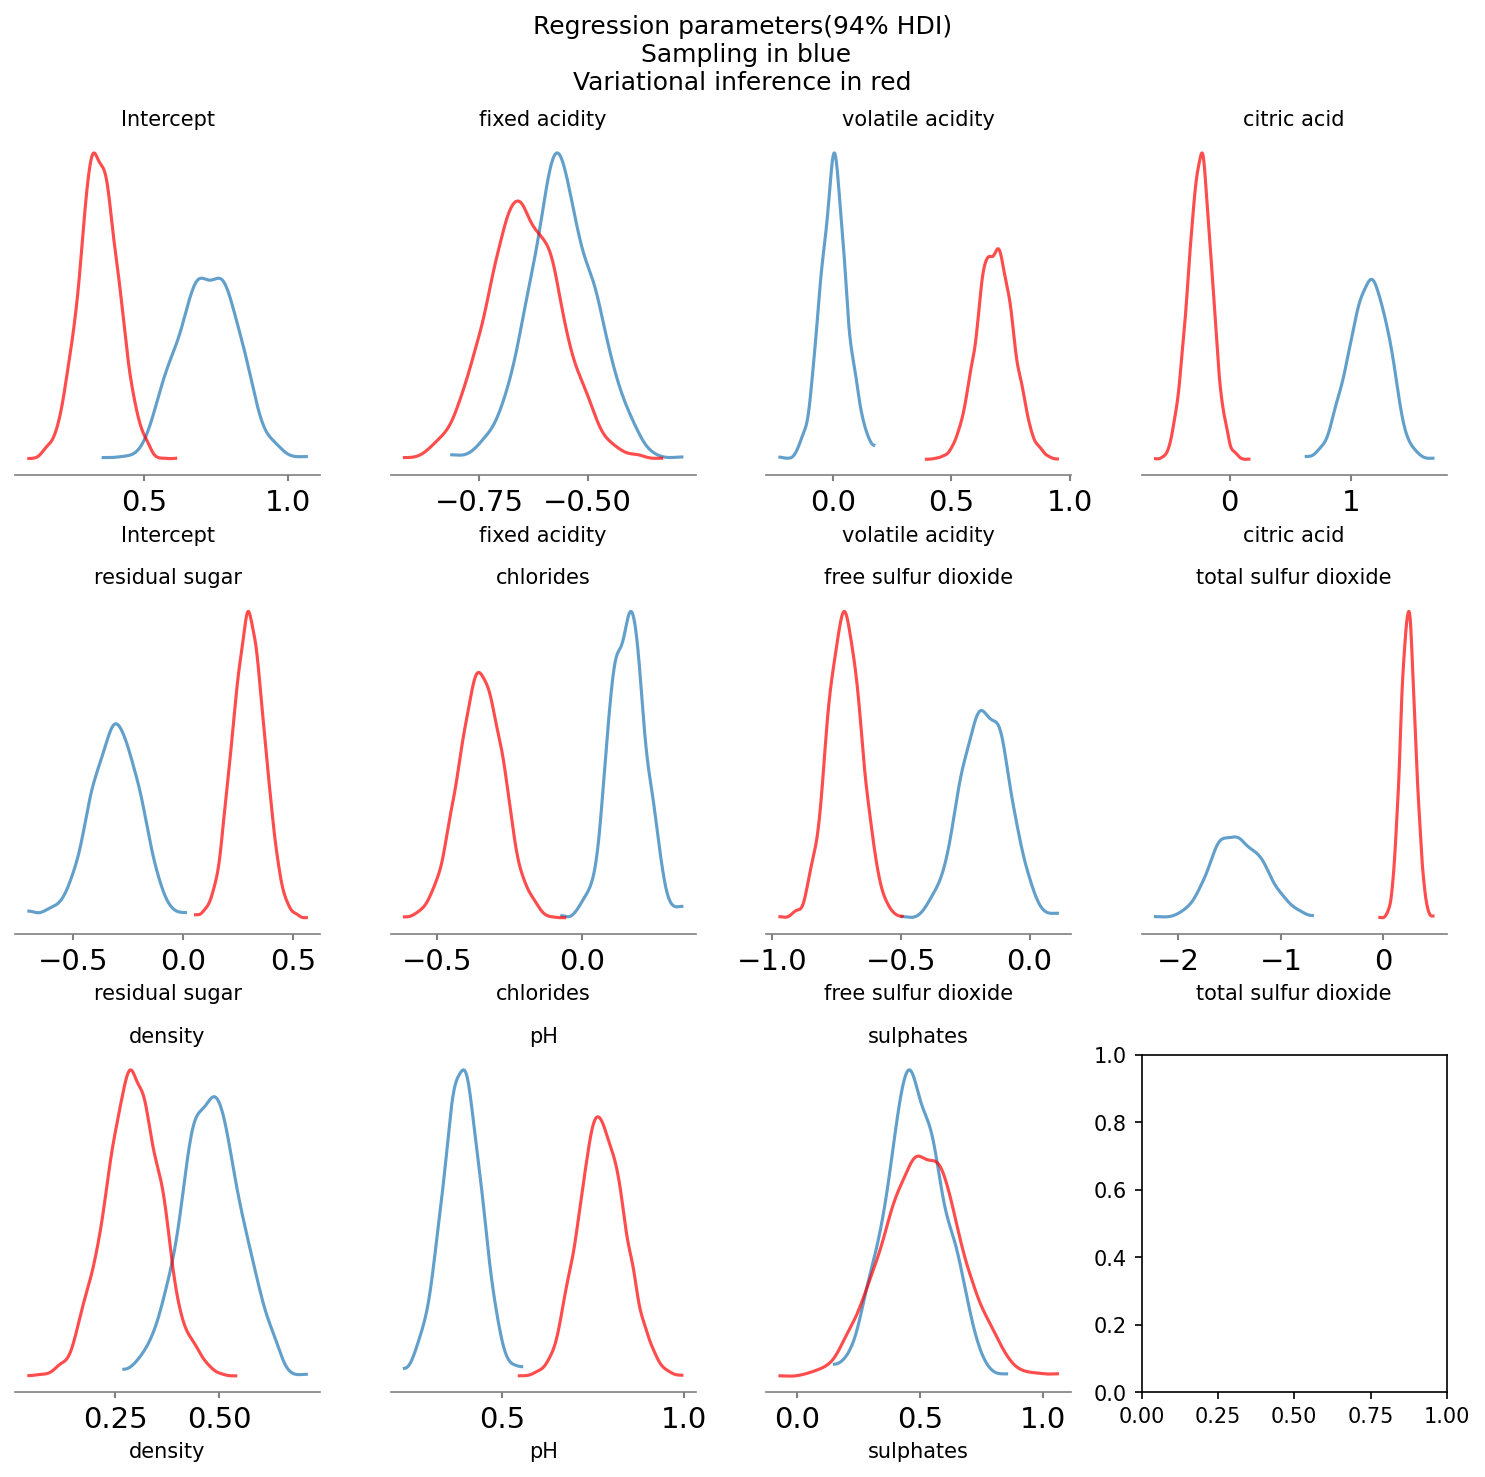

In [49]:
# Comparative plots of the regression parameters

burnin = 1000
# sample_intercept = trace_main.posterior['B0']
# sample_betas = trace_main.posterior['B'].mean(axis =0)[burnin:]
sample_betas = trace_main.posterior['B']
# advi_intercept = advi_trace.posterior['B0']
advi_betas = advi_trace.posterior['B']

# Plot posteriors

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 10), dpi=150, constrained_layout=False)

for ax, estimate_sampling, estimate_advi, title, xlabel in zip(axes.ravel(),
                               #[sample_betas[:,i] for i in range(k+1)],
                               [sample_betas[0,:,i] for i in range(k-1)],
                               [advi_betas[0,:,i] for i in range(k-1)],
                               ['Intercept'] + numeric_predictors + ['type'],
                               ['Intercept'] + numeric_predictors + ['type']):
    
    pm.plot_posterior(estimate_sampling, ax=ax,point_estimate=None, hdi_prob= 'hide', alpha=0.7)
    pm.plot_posterior(estimate_advi, ax=ax, color='red', point_estimate=None, hdi_prob= 'hide', alpha=0.7)
    
    ax.set_title(title, fontsize=10)

    ax.set_xlabel(xlabel, fontsize=10)
    
plt.suptitle("Regression parameters(94% HDI)\n Sampling in blue\nVariational inference in red")
plt.tight_layout()
#plt.subplots_adjust(top=0.75)
plt.show()

The plots show that there are several predictors inwhich the posterior estimates for variational and sampling approaches are not close. This makes sense as they seem to be the values that have higher correlations. We also see that the red lines - indicating the variational inference approach - are more uniform in spread, as we saw in the forest plot above. 